In [15]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.bandwidths import bw_silverman

In [2]:
import sys
sys.path.append('../')  # go to parent dir

### 4.10.1 European Stock Indices

In [3]:
prices = pd.read_csv('../data/EuStockMarkets.csv', index_col=0, usecols=[1, 2, 3, 4, 5])
prices.head()

,DAX,SMI,CAC,FTSE
date,,,,
1991.496154,1628.75,1678.1,1772.8,2443.6
1991.500000,1613.63,1688.5,1750.5,2460.2
1991.503846,1606.51,1678.6,1718.0,2448.2
1991.507692,1621.04,1684.1,1708.1,2470.4
1991.511538,1618.16,1686.6,1723.1,2484.7


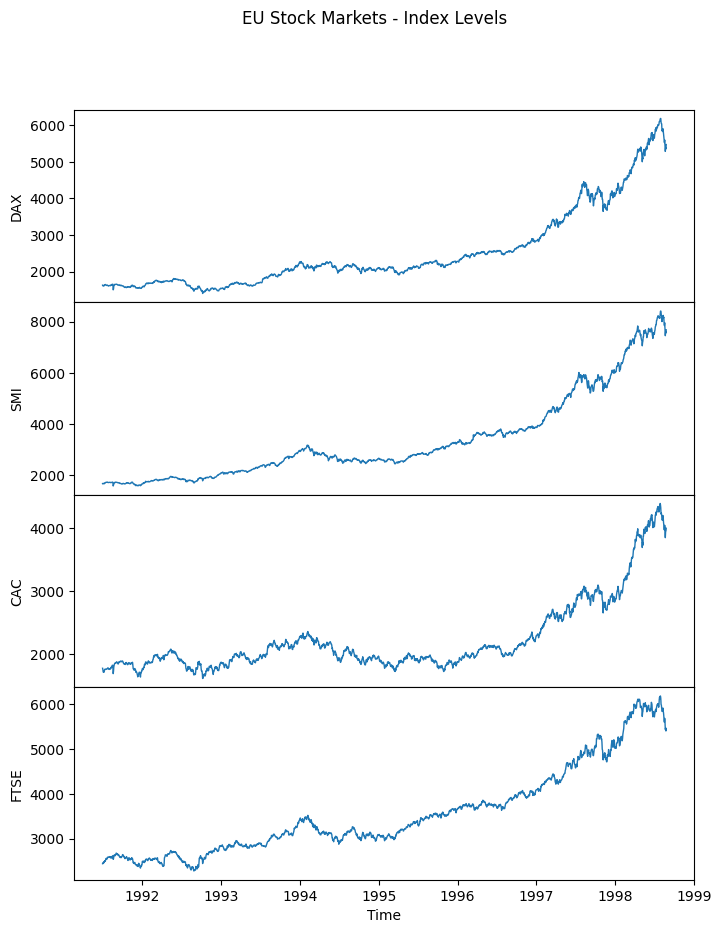

In [4]:
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(4, 1, hspace=0)
axs = gs.subplots()
fig.suptitle('EU Stock Markets - Index Levels')
for i in range(4):
    axs[i].plot(prices.iloc[:, i], linewidth=1)
    axs[i].set_ylabel(prices.columns[i])
    axs[i].set_xlabel('Time')
    axs[i].label_outer()

The series are clearly not stationary with fluctuations of varying size.

In [5]:
ret = np.log(prices).diff().dropna()

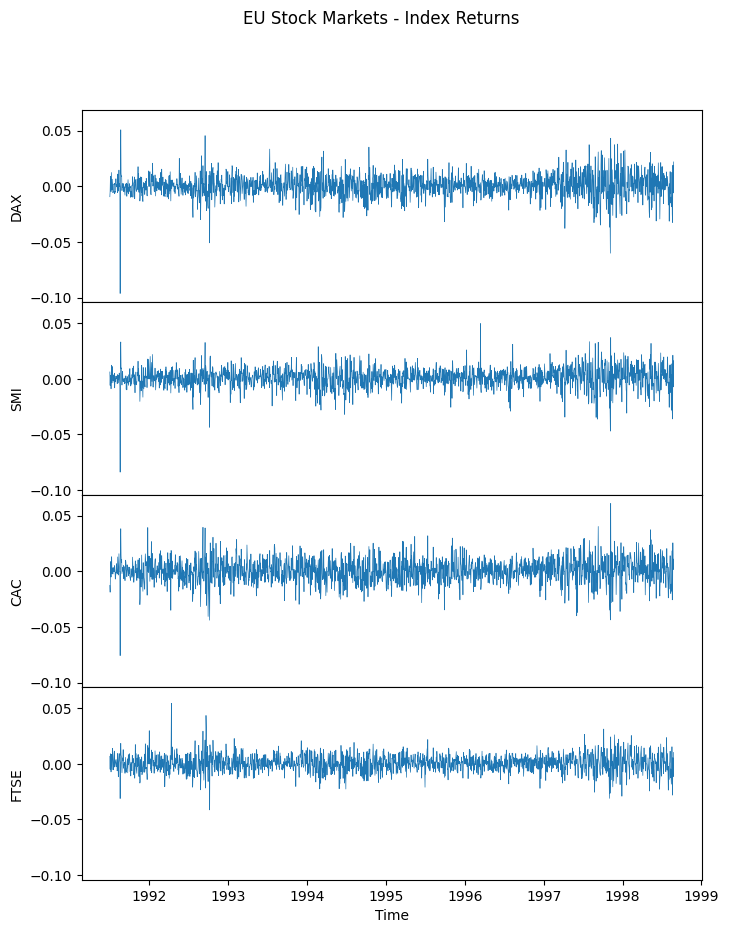

In [6]:
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(4, 1, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('EU Stock Markets - Index Returns')
for i in range(4):
    axs[i].plot(ret.iloc[:, i], linewidth=0.5)
    axs[i].set_ylabel(ret.columns[i])
    axs[i].set_xlabel('Time')
    axs[i].label_outer()

The time series of returns look stationary, however they appear to exhibit conditional heteroskedasticity.

To produce pairwise scatter plots:

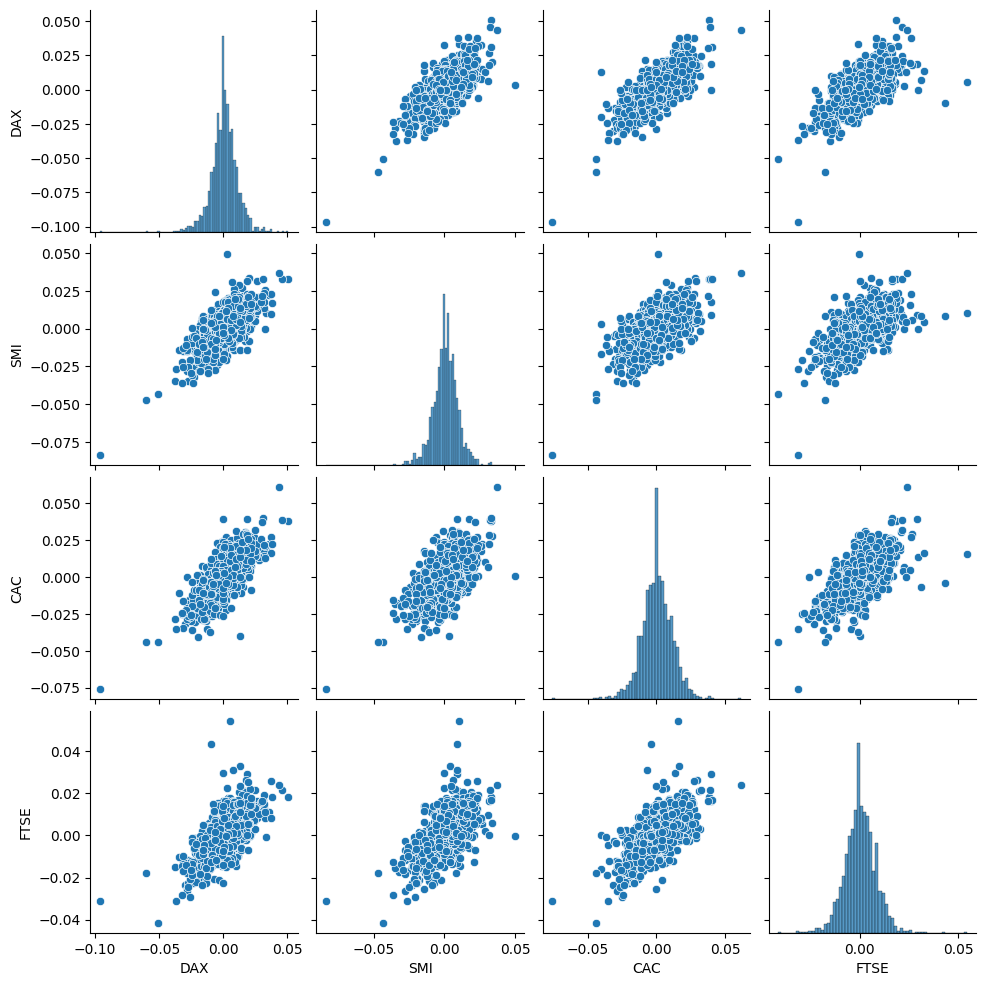

In [9]:
sns.pairplot(ret);

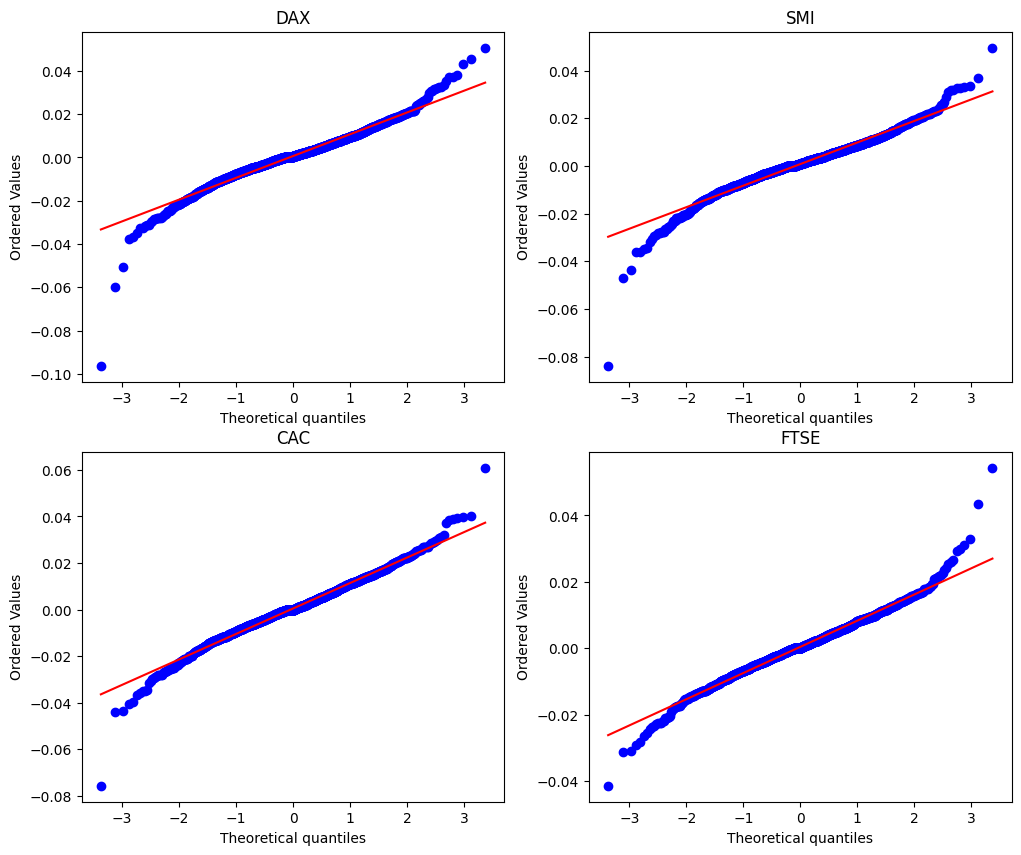

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i in range(4):
    stats.probplot(ret.iloc[:, i], dist="norm", plot=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title(ret.columns[i])
plt.show()

The empirical distributions appear symmetrical and heavy-tailed.

Based on the results of the Shapiro-Wilk test, we reject the null hypothesis that the returns are normally distributed.

In [12]:
pd.DataFrame([[sw.statistic, sw.pvalue] for col in ret.columns if (sw := stats.shapiro(ret[col]))], index=ret.columns, columns=['Statistic', 'p-value'])

,Statistic,p-value
DAX,0.953837,8.781931e-24
SMI,0.955371,2.077338e-23
CAC,0.982033,1.575066e-14
FTSE,0.979939,1.750021e-15


In [13]:
def plot_qq(ret, name, dfs):
    qs = np.array([0.25, 0.75])
    
    rows = math.ceil(len(dfs) / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(12, 4 * rows))
    fig.suptitle(name)
    for i, df in enumerate(dfs):
        ax = axs[i // 2][i % 2]
        stats.probplot(ret, dist="t", sparams=df, plot=ax, fit=False)
        
        # draw a regression line through 0.25 and 0.75 quantiles
        coord = lambda q: (stats.t.ppf(q, df), np.quantile(ret, q))
        ax.axline(coord(qs[0]), coord(qs[1]), color='red')
        
        ax.set_title(f'df = {df}')
        ax.set_xlabel('')
    plt.show()

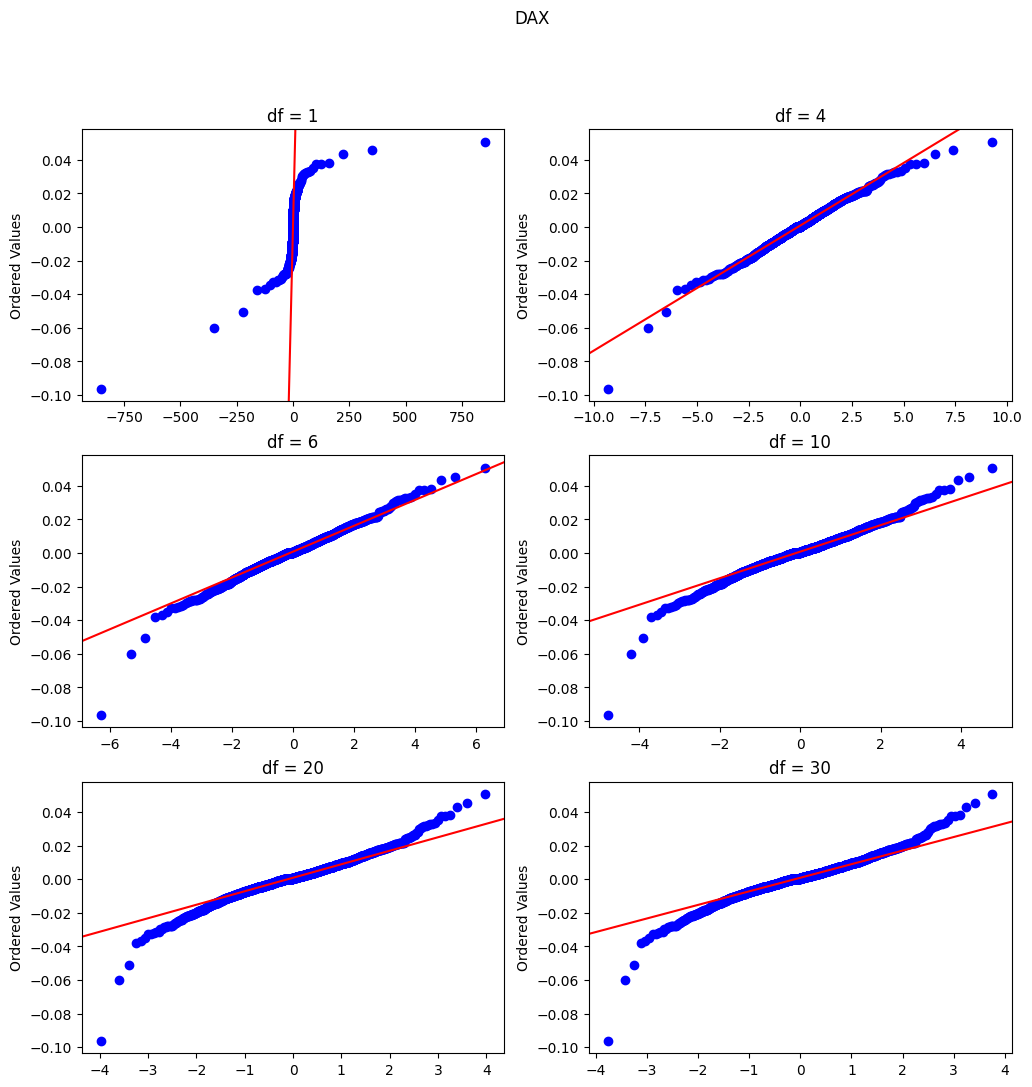

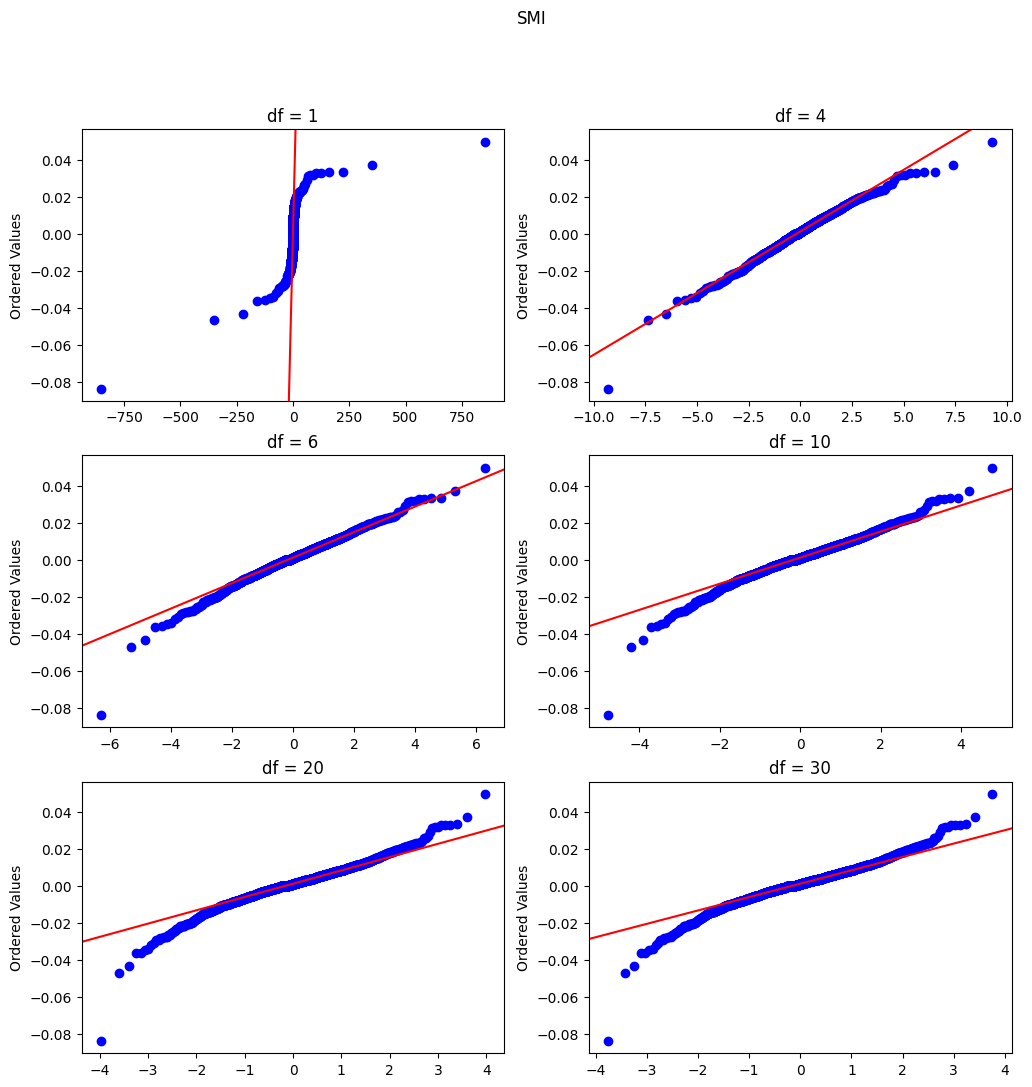

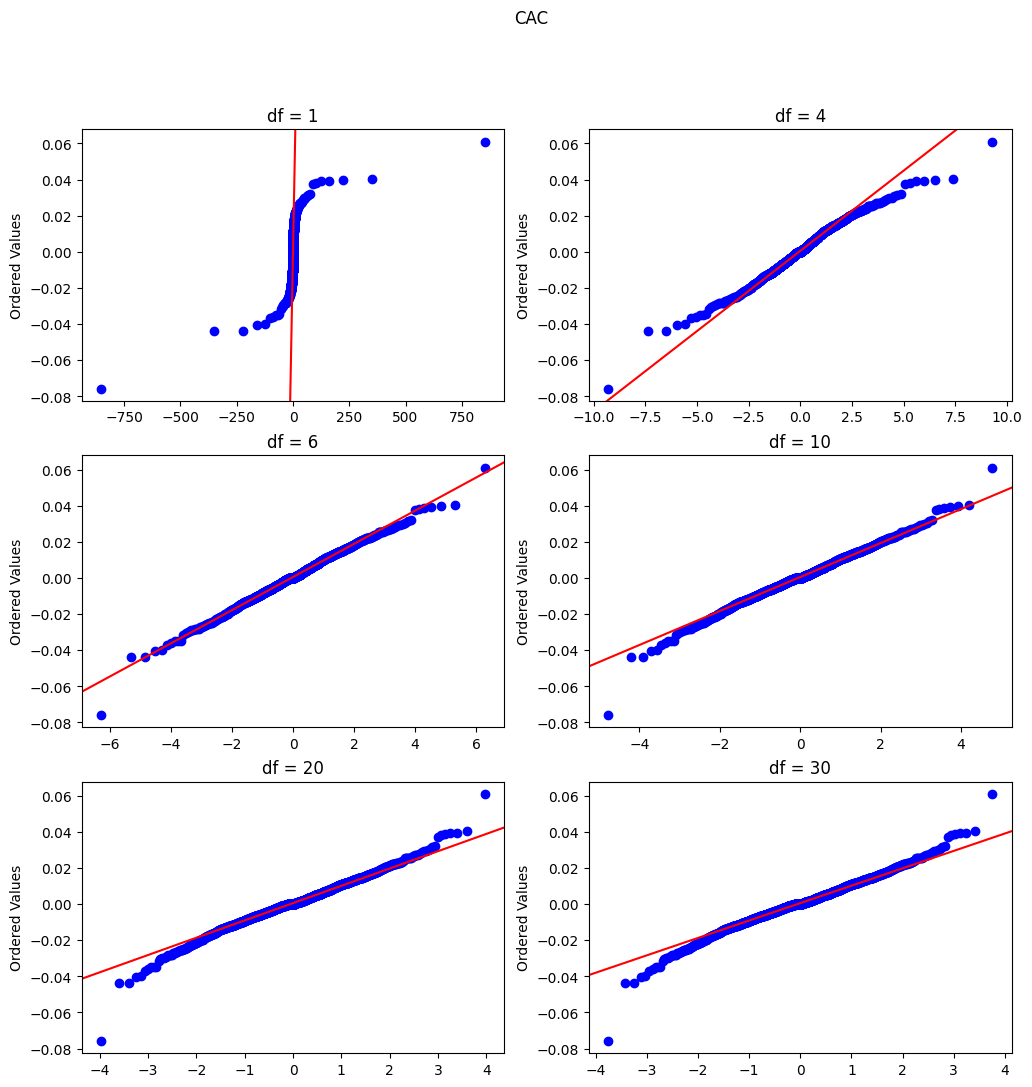

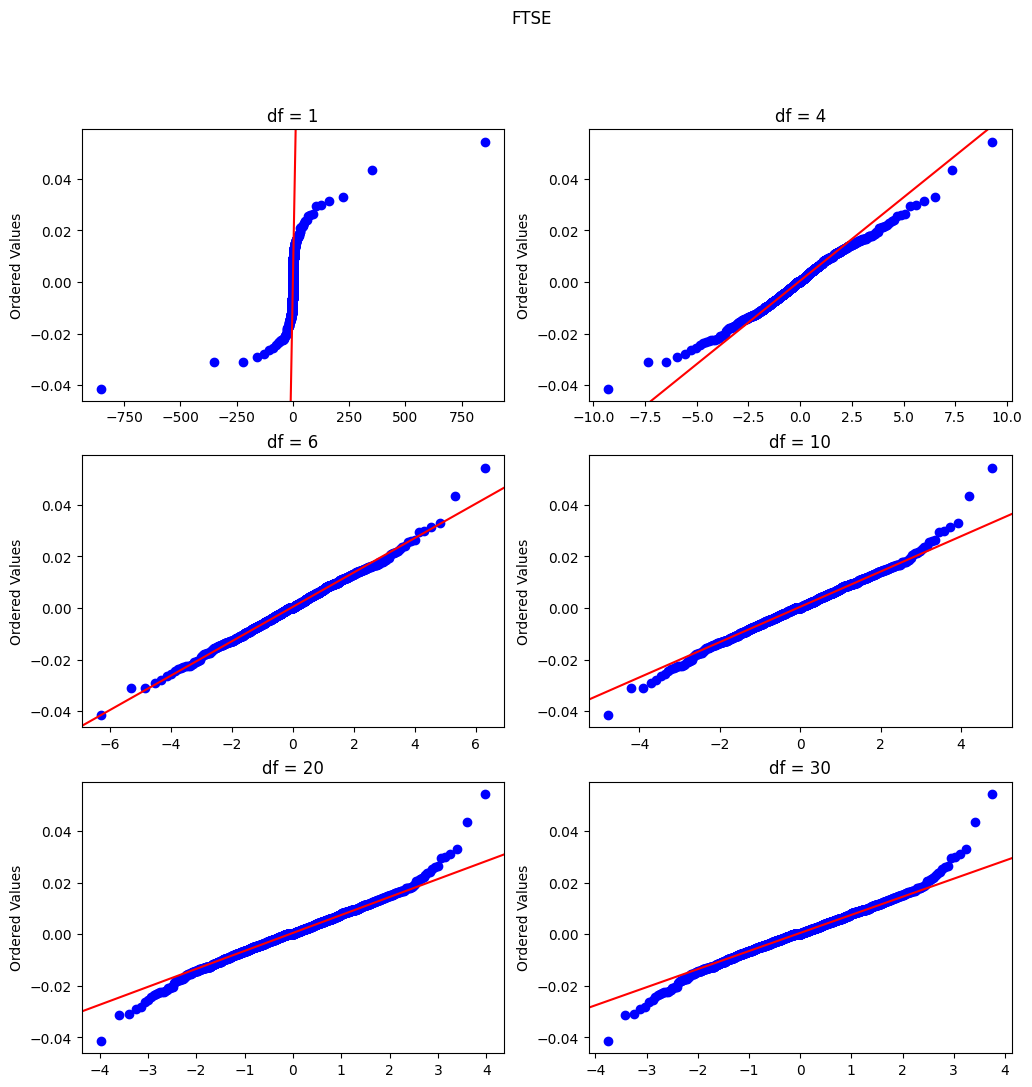

In [14]:
dfs = [1, 4, 6, 10, 20, 30]
for col in ret.columns:
    plot_qq(ret[col], col, dfs)

For DAX, the t-distribution with 6 degrees of freedom appears to give the best fit.

In [14]:
stats.median_abs_deviation(ret['DAX'], scale='normal')

0.008121375774598111

In [17]:
df = 5

In [18]:
mad_t = stats.median_abs_deviation(ret['DAX'], scale=stats.t.ppf(0.75, df))
mad_t

0.00753802654363222

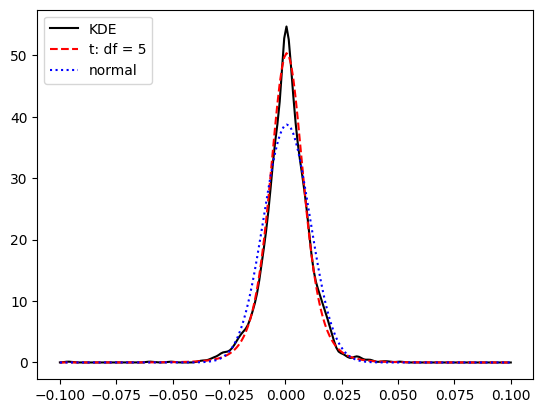

In [19]:
def plot_density(ret):
    kde = KernelDensity(bandwidth=bw_silverman(ret), kernel='gaussian').fit(ret.values.reshape(-1, 1))

    xs = np.linspace(-0.1, 0.1, 200)
    vals = kde.score_samples(xs.reshape(-1, 1))

    fig, ax = plt.subplots()
    ax.plot(xs, np.exp(vals), color='black', label='KDE')
    ax.plot(xs, stats.t.pdf(xs, df=df, loc=np.mean(ret), scale=mad_t), '--', color='red', label=f't: df = {df}')
    ax.plot(xs, stats.norm.pdf(xs, loc=np.mean(ret), scale=np.std(ret, ddof=1)), ':', color='blue', label='normal')

    ax.legend(loc='upper left')

plot_density(ret['DAX'])

Note that in the R implementation, ``dstd`` implements a normalised Student's t-distribution, hence the need to multiply the mad by $\sqrt{\frac{df}{df - 2}}$, whereas ``scipy.stats.t`` implements the usual t-distribution, so the value of ``mad_t`` does not require this adjustment.

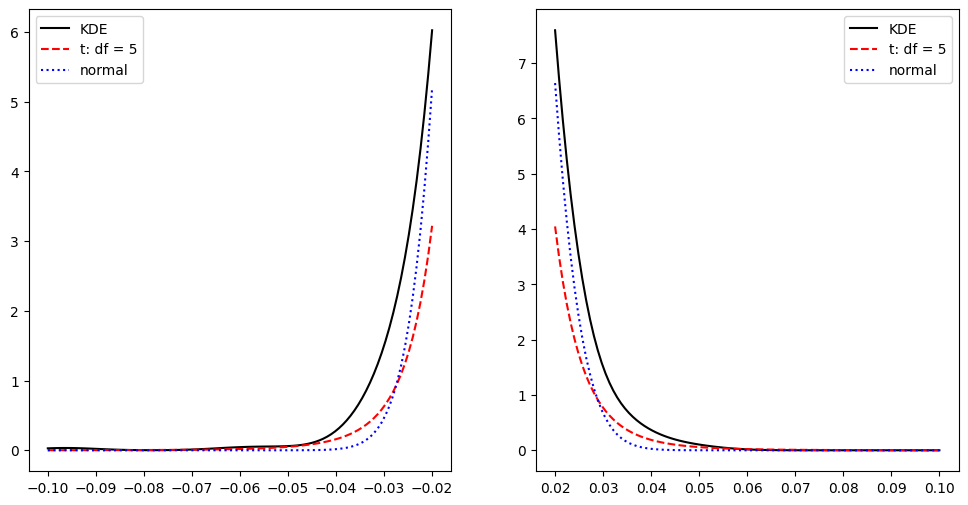

In [20]:
def plot_tails(ret):
    bw_adjust = 4  # increase the bandwidth to smoothen the tails
    
    kde = KernelDensity(bandwidth=bw_adjust * bw_silverman(ret), kernel='gaussian').fit(ret.values.reshape(-1, 1))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    xs = np.linspace(-0.1, -0.02, 100)
    vals = kde.score_samples(xs.reshape(-1, 1))

    axs[0].plot(xs, np.exp(vals), color='black', label='KDE')
    axs[0].plot(xs, stats.t.pdf(xs, df=df, loc=np.mean(ret), scale=mad_t), '--', color='red', label=f't: df = {df}')
    axs[0].plot(xs, stats.norm.pdf(xs, loc=np.mean(ret), scale=np.std(ret, ddof=1)), ':', color='blue', label='normal')
    axs[0].legend(loc='upper left')
    
    xs = np.linspace(0.02, 0.1, 100)
    vals = kde.score_samples(xs.reshape(-1, 1))
    
    axs[1].plot(xs, np.exp(vals), color='black', label='KDE')
    axs[1].plot(xs, stats.t.pdf(xs, df=df, loc=np.mean(ret), scale=mad_t), '--', color='red', label=f't: df = {df}')
    axs[1].plot(xs, stats.norm.pdf(xs, loc=np.mean(ret), scale=np.std(ret, ddof=1)), ':', color='blue', label='normal')
    axs[1].legend(loc='upper right')

plot_tails(ret['DAX'])

The t-distribution provides a reasonably good fit for the empirical data.

The default bandwidth in R's ``density`` function uses Silverman's rule of thumb (https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/bandwidth: Silverman (1986, page 48, eqn (3.31)). The default kernel is gaussian.

For CAC, a t-distribution with 6 degrees of freedom offers the best fit.

### 4.10.2 McDonald's Price and Returns

In [21]:
mcd_price = pd.read_csv('../data/MCD_PriceDaily.csv', index_col=0, parse_dates=[0])
mcd_price.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,62.63,63.07,62.31,62.78,5839300,53.99
2010-01-05,62.66,62.75,62.19,62.30,7099000,53.58
2010-01-06,62.20,62.41,61.06,61.45,10551300,52.85
2010-01-07,61.25,62.34,61.11,61.90,7517700,53.24
2010-01-08,62.27,62.41,61.60,61.84,6107300,53.19


In [22]:
adj_price = mcd_price['Adj Close']

The price time series is obviously non-stationary:

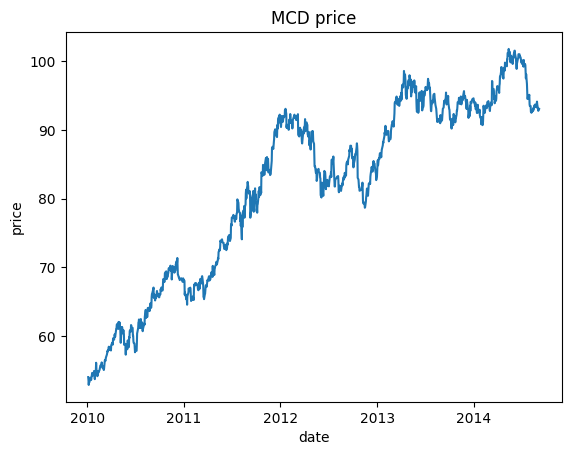

In [23]:
fig, ax = plt.subplots()
ax.plot(adj_price)
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('MCD price');

In [24]:
log_ret = np.log(adj_price).diff().dropna()

The returns time series visually appears to be stationary:

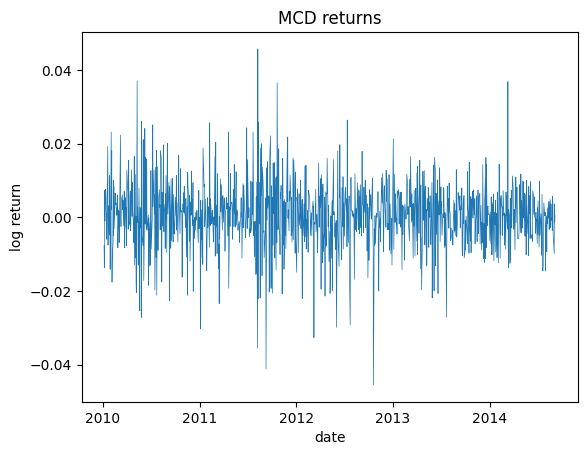

In [25]:
fig, ax = plt.subplots()
ax.plot(log_ret, linewidth=0.5)
ax.set_xlabel('date')
ax.set_ylabel('log return')
ax.set_title('MCD returns');

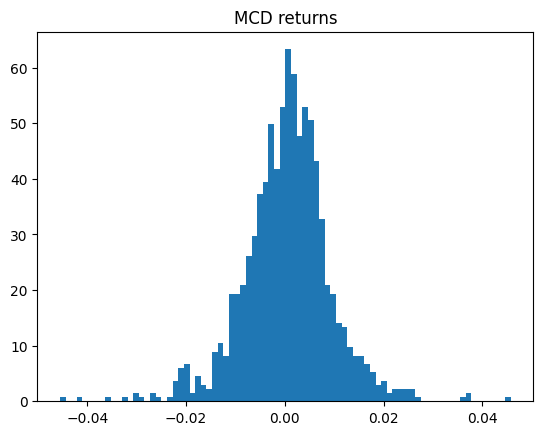

In [26]:
fig, ax = plt.subplots()
ax.hist(log_ret, bins=80, density=True)
ax.set_title('MCD returns');

The histogram suggest slight left-skewness:

In [27]:
stats.skew(log_ret)

-0.16042138396194558

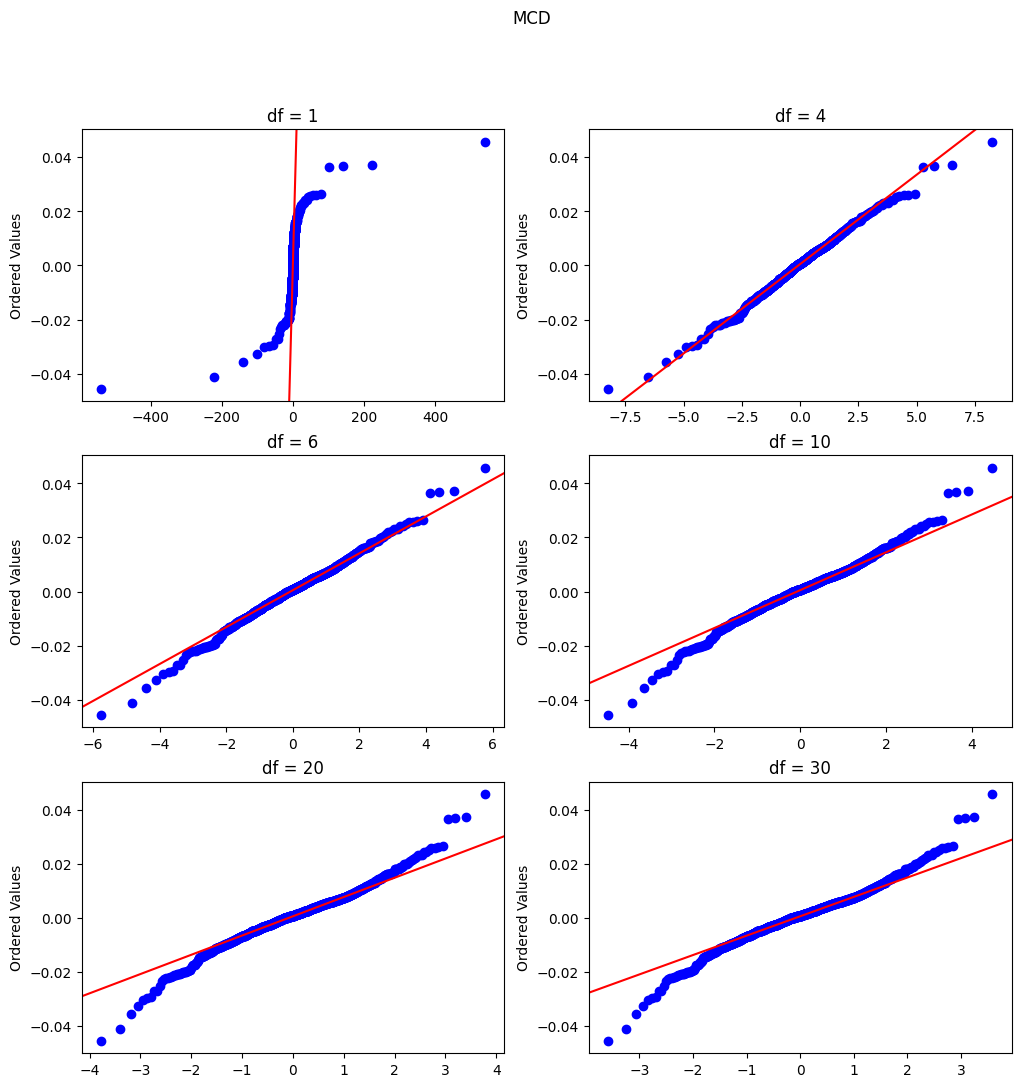

In [28]:
plot_qq(log_ret, 'MCD', dfs)

The returns appear to have heavy tails with the left tail being slightly heavier than the right tail. A t-distribution with 6 degrees of freedom provides the best fit of the options.